In [204]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

**Loading MNIST handwritten digits dataset**

In [143]:
training_data = np.loadtxt('mnist_train.csv', delimiter=',', dtype=np.float32)
test_data     = np.loadtxt('mnist_test.csv',  delimiter=',', dtype=np.float32)

In [347]:
X_train = torch.from_numpy(training_data[:,1:])
y_train = torch.from_numpy(np.array(training_data[:,0], dtype=np.int64))
X_test  = torch.from_numpy(test_data[:,1:])
y_test  = torch.from_numpy(np.array(test_data[:,0], dtype=np.int64))

**Each row of X is a flattened 28 x 28 image. Therefore, the row length i.e. the number of columns should be 28 x 28 = 784.**

In [348]:
# getting the number of columns
Xcols = X_train.shape[1]

# testing the number of columns
if Xcols != 784:
    print('Problem: row length of X_train is not 784 (28 x 28) as expected.')
else:
    print('Row length of X_train is 784 so it seems to be read in correctly.')

Row length of X_train is 784 so it seems to be read in correctly.


**To check further let's visualise the dataset.**

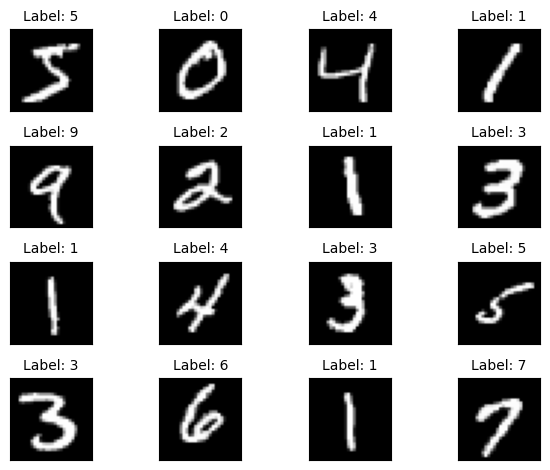

In [349]:
img_sz = 28 # 28 x 28 image
N = 4 # checking 4 x 4 = 16 images

fig, axs = plt.subplots(nrows=N, ncols=N)

for j in range(N):
    for i in range(N):
        idx = j * N + i
        image = X_train[idx].reshape(img_sz,img_sz)
        n = int(y_train[j * N + i])
        axs[j,i].imshow(image, cmap='gray')
        axs[j,i].set_title(f'Label: {n}', fontsize='medium')

for ax in axs.flat:
    ax.xaxis.set_ticks([]); ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticks([]); ax.yaxis.set_ticklabels([])

fig.tight_layout()

**Now that our training data seem to be read in correctly, we should be able to train our neural network.**

We can't just forward all of our input data per training step: need to forward minibatches. We also need to decide on the model architecture.

**Model architecture**

In [350]:
# Architecture:
# 1. inputs (X)
# 2. minibatching (Xb)
# 3. linear layer (W1, b1)
# 4. tanh activation layer (act)
# 5. linear layer (W1, b1)
# 6. cross entropy loss (scalar var called loss)

Xrows = X_train.shape[0]
Xcols = X_train.shape[1]

batch_sz = 32
B = batch_sz
n_hid1 = 100 # number of neurons in first hidden layer
n_hid2 = 10 # number of neurons in second hidden layer; must equal number of output channels, i.e. digits 0 - 9

# parameter/layer tensors
Xb = torch.zeros((B, Xcols))
W1 = torch.randn((Xcols,n_hid1))
b1 = torch.randn((1, n_hid1))
lin1 = torch.zeros((B, n_hid1))
act = torch.zeros((B, n_hid1))
W2 = torch.randn((n_hid1,n_hid2))
b2 = torch.randn((1, n_hid2))
logits = torch.zeros((B, n_hid2))
loss = 0

# gradient tensors
dLdlogits = torch.zeros((B, n_hid2)) # dL/dloss   * dlossd/logits; dLdloss = 1
dLdb2 = torch.randn((1, n_hid2))     # dL/dlogits * dlogits/db2
dLdW2 = torch.randn((n_hid1,n_hid2)) # dL/dlogits * dlogits/dW2
dLdact = torch.zeros((B, n_hid1))    # dL/dlogits * dlogits/dact
dLdlin1 = torch.zeros((B, n_hid1))   # dL/dact    * dact/dlin1
dLdb1 = torch.randn((1, n_hid1))     # dL/dlin1   * dlin1/db1
dLdW1 = torch.randn((Xcols,n_hid1))  # dL/dlin1   * dlin1/dW2

params = [W1, b1, W2, b2]
for p in params:
    p.requires_grad = True
grads = [dLdW1, dLdb1, dLdW2, dLdb2]

epochs = 1000
losses = []

**Doing a single forward pass**

In [351]:
rows = torch.randint(0, Xrows, (B, ))
Xb = X_train[rows]
yb = y_train[rows]
lin1 = Xb @ W1 + b1
act = torch.tanh(lin1)
logits = act @ W2 + b2
loss = F.cross_entropy(logits, yb) # basically, y[rows] indexes into the correct output column in logits to compute the loss

for p in params:
    p.grad = None

for t in [logits, act, lin1]:
    t.retain_grad()

loss.backward()

**Doing a single backward pass manually and comparing against pytorch gradients**

In [342]:
# utility function to compare manual vs pytorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

dLdlogits = F.softmax(logits, dim=1) 
dLdlogits[range(B), yb] -= 1 # not sure why a[:,yb] doesn't work compared to a[range(n),yb] 
dLdlogits /= B
dLdact = dLdlogits @ W2.T # (B, n_hid1) = (B, n_hid2) @ (n_hid2, n_hid1)
dLdW2 = act.T @ dLdlogits # dimensions must work out: (n_hid1, n_hid2) = (n_hid1, B) @ (B, n_hid2)
dLdb2 = dLdlogits.sum(dim=0, keepdims=True) # (1, n_hid2) = (1, B) @ (B, n_hid2)
dLdlin1 = dLdact * (1 - torch.tanh(lin1) ** 2)
dLdW1 = Xb.T @ dLdlin1 # (Xcols, n_hid1) = (Xcols, X) @ (X, n_hid1)
dLdb1 = dLdlin1.sum(dim=0, keepdims=True)

cmp('logits', dLdlogits, logits)
cmp('act', dLdact, act)
cmp('W2', dLdW2, W2)
cmp('b2', dLdb2, b2)
cmp('lin1', dLdlin1, lin1)
cmp('W1', dLdW1, W1)
cmp('b1', dLdb1, b1)

logits          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
act             | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
W2              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
b2              | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
lin1            | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


**Training loop**

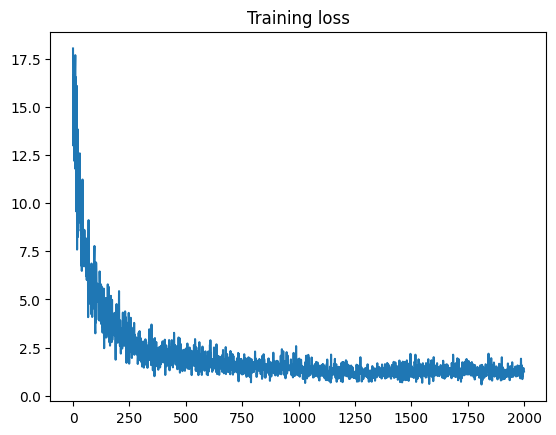

In [344]:
lr = 0.1

for e in range(epochs):
    # generating a tensor of size B containing random ints ranging from 0 to Xrows - 1 (Xrows is exclusive)
    # used for indexing purposes to generate a random minibatch
    rows = torch.randint(0, Xrows, (B, ))
    Xb = X_train[rows]
    yb = y_train[rows]
    lin1 = Xb @ W1 + b1
    act = torch.tanh(lin1)
    logits = act @ W2 + b2
    loss = F.cross_entropy(logits, yb) # basically, y[rows] indexes into the correct output column in logits to compute the loss

    # zeroing grads before backward
    for p in params:
        p.grad = None

    # pytorch backward and parameter update
    '''loss.backward()
    for p in params:
        p.data -= lr * p.grad'''
    
    # manual backward and parameter update
    dLdlogits = F.softmax(logits, dim=1) 
    dLdlogits[range(B), yb] -= 1
    dLdlogits /= B
    dLdact = dLdlogits @ W2.T
    dLdW2 = act.T @ dLdlogits
    dLdb2 = dLdlogits.sum(dim=0, keepdims=True)
    dLdlin1 = dLdact * (1 - torch.tanh(lin1) ** 2)
    dLdW1 = Xb.T @ dLdlin1
    dLdb1 = dLdlin1.sum(dim=0, keepdims=True)
    
    # if the gradients are not explicitly set every iteration, it doesn't work, not sure why.
    grads = [dLdW1, dLdb1, dLdW2, dLdb2]
    
    for p, g in zip(params, grads):
        p.data -= lr * g.data
    
    losses.append(loss.item())

plt.plot(losses)
plt.title('Training loss');

**Computing test loss**

In [345]:
def compute_test_loss(X_test, y_test):
    with torch.no_grad():
        lin1 = X_test @ W1 + b1
        act = torch.tanh(lin1)
        logits = act @ W2 + b2
        loss = F.cross_entropy(logits, y_test)
    return loss

test_loss = compute_test_loss(X_test, y_test)
print(f'Training loss: {losses[-1]}, test loss: {test_loss}')

Training loss: 1.2472290992736816, test loss: 1.3333871364593506


**Making and comparing predictions**

In [346]:
def do_inference(X, y):
    with torch.no_grad():
        lin1 = X @ W1 + b1
        act = torch.tanh(lin1)
        logits = act @ W2 + b2
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(probs) # take the prediction to be the output channel with the highest probability
    return pred

N = 10

print(f'{'Actual':<8} {'Prediction':<12}')
print('-' * 8, '-' * 12)

for i in range(N):
    idx = random.randint(0,X_test.shape[0]-1)
    X = X_test[idx]
    y = y_test[idx]
    pred = do_inference(X, y)
    print(f'{y:<8} {pred:<12}')

Actual   Prediction  
-------- ------------
4        8           
5        7           
7        4           
9        7           
7        7           
1        1           
8        6           
3        3           
9        4           
6        7           
